# Building a regression model for predicting house sale prices

In [5]:
import pickle
import pathlib

import numpy as np
import pandas as pd

In [6]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\marce\Desktop\Machine learning\ames_AndreVictor\data


In [7]:
clean_data_path = DATA_DIR / 'processed' / 'ames_transformed.pkl'

In [8]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2872 non-null   category
 1   MS.Zoning        2872 non-null   category
 2   Lot.Frontage     2872 non-null   float64 
 3   Lot.Area         2872 non-null   float64 
 4   Lot.Shape        2872 non-null   category
 5   Land.Contour     2872 non-null   category
 6   Lot.Config       2872 non-null   category
 7   Land.Slope       2872 non-null   category
 8   Neighborhood     2872 non-null   category
 9   Bldg.Type        2872 non-null   category
 10  House.Style      2872 non-null   category
 11  Overall.Qual     2872 non-null   category
 12  Overall.Cond     2872 non-null   category
 13  Roof.Style       2872 non-null   category
 14  Mas.Vnr.Type     2872 non-null   category
 15  Mas.Vnr.Area     2872 non-null   float64 
 16  Exter.Qual       2872 non-null   category


In [10]:
model_data = data.copy()

## Preparing the data for the model

Now that we have the data all cleaned, and all the missing values accounted for, lets focus on transforming the data for the model.

Lets remember what a model is. 

- A predictive model is a **set** of functions that receive data as input and produce a prediction, that is, an estimate of the target value as output.
- **Train** a model is to search the set of candidate functions for one that adequately represents the **training dataset**.
- The adequacy of a candidate function to the training data is usually determined by a **loss function** that measures how well the predictions of the function match the real values of the target within the training dataset. It is common to define a *loss function per data item* (e.g. absolute error, quadratic error, etc) and to construct the *loss function over the dataset* as the *average prediction loss*.

Many models are **parametric models**. In this case, each function of the set of functions that makes the model is constructed from a vector of **parameters** that define the function, forming a **parametric function**. For instance: the linear model constructs prediction values out of a linear combination of the input features, plus a constant. The weights of the linear combination plus the constant are the parameters of the model. The set of functions that can be represented by this model is given by all possible values of the vector of parameters that define the function.

Some models are called **non-parametric models**. These models usually do not have a parametric form (like the linear model). But the terminology is a bit misleading, though: usually these models *do* have parameters, and potentially an open-ended set of them! For instance, consider the "decision tree" model, which is one of the most prominent models of this category. The decision tree may not have a formula for the predicted value, but it does have parameters, many of them: each decision in the tree involves a choice of feature and a threshold level, and those choices must be stored as parameters of the model for use in future predictions.

Each model has specific requirements for the format of the input data. Most of the time, the minimum requirement is that:

- All columns are numeric;
- There are no missing values.

Some models have extra requirements. For example: the support-vector-machines model requires that the input features have comparable standard deviations - having features that have large discrepancies between features in terms of their order of magnitude (such as a feature in the fractions of unit range and another in the tens of thousands) will result in poor prediction quality.

And some models may not have any special requirement at all. We will study each of those in detail in this course.

Lets start our study with a simple model: the *multivariate linear regression* model. This is a model that presents the minimum requirements listed above. So we need to do a bit of processing on the original features:

- *Numerical features* stay as given;
- *Categorical features* have to be transformed into numerical features. In order to do so we need to **encode** these features, that is: to transform them into new features that convey the same information, but in a numerical form, and in a way that "makes sense" - we'll see it below.
- *Ordinal features* can be transformed into numerical features in the same way as the caegorical features, or could be assigned increasing numbers in conformity with the ordered nature of the categories of the feature.

## Encoding categorical variables

Lets identify all categorical variables - both nominal (that is, categoricals without category order) and ordinal.

In [11]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [12]:
ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [13]:
categorical_columns

['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

### Encoding ordinal variables 

Ordinal variables can be transformed into integer numbers in a straightforward manner: the lowest category is assigned the value "zero", the next category is given the value "one", etc. The `Pandas` library has a function for this task: `factorize()`:

In [14]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

Lets confirm that the variables are no longer ordinal, but now are integers:

In [15]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Lot.Shape     2872 non-null   int64
 1   Land.Slope    2872 non-null   int64
 2   Overall.Qual  2872 non-null   int64
 3   Overall.Cond  2872 non-null   int64
 4   Exter.Qual    2872 non-null   int64
 5   Exter.Cond    2872 non-null   int64
 6   Heating.QC    2872 non-null   int64
 7   Electrical    2872 non-null   int64
 8   Kitchen.Qual  2872 non-null   int64
 9   Functional    2872 non-null   int64
 10  Paved.Drive   2872 non-null   int64
 11  Fence         2872 non-null   int64
dtypes: int64(12)
memory usage: 291.7 KB


Compare the original values with the encoded values:

In [16]:
data['Lot.Shape'].value_counts()

Reg    1825
IR1     956
IR2      76
IR3      15
Name: Lot.Shape, dtype: int64

In [17]:
model_data['Lot.Shape'].value_counts()

0    1825
1     956
2      76
3      15
Name: Lot.Shape, dtype: int64

In [18]:
model_data[ordinal_columns].head(10)

,Lot.Shape,Land.Slope,Overall.Qual,Overall.Cond,Exter.Qual,Exter.Cond,Heating.QC,Electrical,Kitchen.Qual,Functional,Paved.Drive,Fence
0,1,0,5,4,2,2,3,0,2,0,1,4
1,0,0,4,5,2,2,2,0,2,0,0,1
2,1,0,5,5,2,2,2,0,1,0,0,4
3,0,0,6,4,1,2,0,0,0,0,0,4
4,1,0,4,4,2,2,1,0,2,0,0,1
5,1,0,5,5,2,2,0,0,1,0,0,4
6,0,0,7,4,1,2,0,0,1,0,0,4
7,1,0,7,4,1,2,0,0,1,0,0,4
8,1,0,7,4,1,2,0,0,1,0,0,4
9,0,0,6,4,2,2,1,0,1,0,0,4


### Encoding nominal variables

With nominal variables there is no notion of order among categories. Therefore, it would be a conceptual mistake to encode them in the same manner as the ordinal variables. For instance, consider the `Exterior` variable:

In [19]:
model_data['Exterior'].value_counts()

VinylSd    1024
HdBoard     438
MetalSd     432
Wd Sdng     400
Plywood     218
CemntBd     124
BrkFace      86
WdShing      55
AsbShng      41
Stucco       41
Other        13
Name: Exterior, dtype: int64

We cannot assign an order here, lest we end up with equations like `HdBoard` + `Plywood` = `CemntBd`, which are nonsense. 

The strategy here to encode `Exterior` is to create several new numerical variables to represent the membership of a given data item to one of the `Exterior` categories. These are called **dummy variables**. Each of these new variables contain only the values "zero" or "one" (i.e. they are binary variables), where $1$ denotes that the data item belongs to the category represented by the variable. Evidently, for a given data item, only one dummy variable has a value of $1$, all remaining are $0$.

There are two types of dummy variable encoding:

- "One-hot" encoding: in this case we create one dummy variable per category. Let's look at the `Exterior` feature as an example. The `Pandas` function `get_dummies()` can do the encoding for us:

In [20]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
AsbShng,0,0,0,0,0
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0


Observe that for each value of `Exterior`, only the corresponding dummy is flagged.

One-hot encoding is a popular technique in Machine Learning. Statisticians, however, prefer a slightly different way of dummy encoding which is:

- Choose a category to *not encode* (this is called the *base category*)
- Generate dummies for the remaining categories. That is:
    - If the data item belongs to the base category, no dummy receives a value of $1$;
    - Otherwise, set the corresponding dummy to $1$.

The same `get_dummies()` function of `Pandas` can do this automatically with the `drop_first` argument:

In [21]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0
Other,0,0,0,0,0


Notice that we are now missing the dummy variable for the `AsbShng` category.

Why to encode things this way? If we don't drop one of the dummies, then it will always be the case that the sum of the values of the dummies is $1$ (since each data item must belong to one of the categories). The linear model, particularly very popular with the statisticians, implies the existence of a fictitious feature containing, for all data items, the value $1$. Hence we end up having a set of variables where a linear combination of them (in this case, the sum of the dummies) matches the value at another variable. This has numerical computing implications for the linear model, that we will discuss in class.

Since we want to use the linear model in this notebook, lets encode all categoricals with the `drop_first` alternative.

In [22]:
model_data = pd.get_dummies(model_data, drop_first=True)

Now our dataset has a lot more variables!

In [23]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(117)
memory usage: 1.4 MB


In [24]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_Sa

## Train-test splitting

The data will now be organized as follows:

- The features form a matrix $X$ of size $m \times n$, where $m$ is the number of data items, and $n$ is the number of features.
- The target forms a column-matrix $y$ of length $m$.

In [25]:
X = model_data.drop(columns=['SalePrice']).copy().values
y = model_data['SalePrice'].copy().values

In [26]:
X, y

(array([[141.0, 31770.0, 1, ..., 0, 0, 0],
        [80.0, 11622.0, 0, ..., 0, 0, 0],
        [81.0, 14267.0, 1, ..., 1, 0, 0],
        ...,
        [62.0, 10441.0, 0, ..., 0, 0, 0],
        [77.0, 10010.0, 0, ..., 0, 0, 0],
        [74.0, 9627.0, 0, ..., 0, 0, 0]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

This is the typical set-up of a machine learning project. Now we want to train our model *and* verify that the model provides good predictions for *unseen* data items. Why the emphasis on "unseen"? Because there is no use for a model that only gives predictions for the items in the data used to train it - we want our models to *generalize*.

The way to assess the model's performance for unseen values is to split the dataset into two subsets: the **training** and **test** datasets.

We have been using a lot of `Pandas` to manipulate our data so far. From now on we will switch to another very popular library for machine learning in Python: `Scikit-Learn`.

The function `train_test_split()` will take as arguments the dataset to be split, the specification of the fraction of the dataset to be reserved for testing, and a random seed value - so that the split will always be the same whenever we run our notebook. This is a customary measure to ensure reproducibility of the notebook.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
RANDOM_SEED = 42  # Any number here, really.

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [30]:
X.shape, Xtrain.shape, Xtest.shape

((2872, 164), (2154, 164), (718, 164))

In [31]:
y.shape, ytrain.shape, ytest.shape

((2872,), (2154,), (718,))

## Fitting a linear model

Lets start with fitting a linear model for regression. The linear model is one of the oldest and most used models for regression, due to its simplicity and strong statistical roots. A proper statistical approach to the understanding of the linear model consists of:

- Understanding the statistical premises of the linear model;
- Analyzing the features to verify that the preliminary conditions of this modeling strategy are satisfied;
- Fitting the model;
- Analyzing the residuals to confirm that the post-fit conditions are satisfied.

Lets discuss these topics in more detail:

### The statistical approach to the linear model

In machine learning we are more interested in the predictive capability of a model, rather than its inductive use to analyze the relation between features and target (or independent and dependent variables, in the statistical terminology). But even to a machine learning practitioner, understanding the statistical basis of the linear model may lead to better predictive performance. For instance:

- Having a symmetrical residual is usually associated with better mean-squared-error (MSE) than having a long-tailed assymmetric residual;
- Non-significant parameters (in a hypothesis-testing sense) may indicate superfluous variables in the model, which could be associated with reduced performance in the test dataset (i.e. poor generalization).

So what is the linear model in statistics? A statistical model is a way to describe probabilistically the relation between features and targets, usually in a parametric way.

Mathematically, we are searching for a *conditional probability* density model of the form $f(Y = y | \mathbf{x}, \theta)$ where $\mathbf{x}$ is the feature vector, $Y$ is the random variable associated with the target, and $\theta$ is the vector of parameters. In plain language, we would like to describe the probability distribution of the target variable when the value of the feature vector is known and the parameters of the model are given.

In the linear model, we postulate that the data $y$ is generated from the feature vector $\mathbf{x}$ plus a random Gaussian noise of fixed standard deviation, as shown in the equation below:

$$
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n + \varepsilon
$$

where $\varepsilon \sim N(0, \sigma)$

The addition of the noise term causes the $y$ value to become a random variable itself, thus making the probabilistic model mentioned above. For a given value of $\mathbf{x}$, the value of $y$ is obtained by adding the constant value $\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$ to a normal random variable $\varepsilon$. Remember that, for normal random variables, adding a constant keeps the variable normal, with a shifted mean-value parameter. Therefore:

$$
Y \sim N(\mu = (\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n), \sigma)
$$

Lets write

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
$$

for simplicity, then the model above is rewritten as:

$$
Y \sim N(\mu = \hat{y}, \sigma)
$$

When we have a dataset $D = \{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \cdots, (\mathbf{x}_m, y_m)\}$ of several $(\mathbf{x}, y)$ pairs, what is their joint conditional probability density function $f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta)$?

We will make another supposition of the linear model: that the $(\mathbf{x}, y)$ examples were obtained independently, and that the value of one does not impact the probability of the other. Therefore:

$$
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) = f(y_1| x_1, \theta) f(y_2| x_2, \theta) \cdots f(y_m| x_m, \theta) 
$$

Remember that the normal probability density function is as follows:

$$
Y \sim N(\mu, \sigma) \Rightarrow f(y) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y - \mu)^2}{\sigma^2} \right)
$$

Thus:

$$
Y \sim N(\mu = \hat{y}, \sigma) \Rightarrow f(y) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y - \hat{y})^2}{\sigma^2} \right)
$$

And the joint conditional probability density function of the entire dataset becomes:


$$
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) = \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right)
$$

Expanding the product we have:

$$
\begin{align*}
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) & = & \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \right) \prod_{i=1}^{m} \left( \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(\sum_{i=1}^{m} \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right)
\end{align*}
$$

What are the "best" value for the parameters of the linear model? We can search for the parameters that maximize the joint conditional probability density function of the dataset. This function is called the *likelihood* of the parameters, and therefore our solution here is called a *"maximum likelihood estimate"* of the parameters.

So we are looking for a value $\theta^{\star}$ of $\theta$ to maximize $f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta)$, that is:

$$
\begin{align*}
\theta^{\star} & = & \argmax_{\theta} \left\{ f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) \right\}\\
& = & \argmax_{\theta} \left\{ \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right) \right\} \\
& = & \argmax_{\theta} \left\{ \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right) \right\} \\
& = & \argmax_{\theta} \left\{ - \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
\end{align*}
$$

Hey, look who we found! Our old friend MSE (mean-squared-error)!

So, in the end, here are the lessons:

- The statistical formulation of the linear model leads to the same error formulation of machine learning, which only cares for the prediction quality.
- The statistical linear model has several assumptions:
    - The samples are independent;
    - The target is *truly* generated from the linear predictive formula plus a normally-distributed error;
    - The error has zero mean and constant standard deviation (the *homoscedasticity* hypothesis);
    - There is no error in the feature measurement. That is, $\mathbf{x}_{i}$ are constants, not random variables. All the error is in the target;
- If the assumptions of the linear model are satisfied, you can analyze the parameters with greater sophistication (the machine learning formulation does not bring this finesse). For instance, you can run hypothesis tests on the values of the parameters to determine whether they refute the null hypothesis $\theta_i = 0$ with a given statistical significance level. Which, in plain language, means that you don't really trust that the associated feature impacts the target, or if it is just an accident.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
#import sgdregressor
from sklearn.linear_model import SGDRegressor

In [33]:
from sklearn.base import BaseEstimator,ClassifierMixin

class DummyModel(BaseEstimator, ClassifierMixin):

    def init(self):
        self.mean = 0

    def fit(self, X, y):
        self.mean = y.mean()
        return self

    def predict(self, X):
        return self.mean[0] * np.ones(shape=[X.shape[0], 1])

In [34]:
baselineModel = LinearRegression()
dummy = DummyModel()

randomForest = RandomForestRegressor()
decTree = DecisionTreeRegressor()
sgdRegressor = SGDRegressor()
elasticModel = ElasticNet()
dummy = DummyModel()


In [35]:
paramsRandomForest = {
    'n_estimators': [50, 100,200],  
    'max_depth': [None, 5, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False] 
}

paramsSGD = {
    'loss': ['squared_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1.0],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-4, 1e-3, 1e-2],
    'random_state': [42]
}

paramsElastic = {
    'alpha': np.arange(0, 1.0, 0.1),  
    'l1_ratio': np.arange(0, 0.501, 0.05)  
}

paramsDecTree = {
    'max_depth': np.arange(2, 11, 1),  
    'min_samples_split': np.arange(2, 11, 1),  
    'min_samples_leaf': np.arange(1, 11, 1), 
    'random_state': [42]
}

paramsList = [paramsElastic,paramsDecTree,paramsRandomForest,paramsSGD]
modelsList = [elasticModel,decTree,randomForest,sgdRegressor]

## Grid Search

In [36]:
from sklearn.model_selection import GridSearchCV
import time



results = {}

for model,params in zip(modelsList,paramsList):
    # grid search for each model and parameters
    grid_search = GridSearchCV(
        model,  # Modelo
        params,  # Grid
        cv=5,  # Partições de C.V.
        scoring='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
    )

    t1 = time.perf_counter()
    grid_search.fit(Xtrain, ytrain)
    t2 = time.perf_counter()

    # Store the results
    results[type(model).__name__] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'mean_test_score': grid_search.cv_results_['mean_test_score'],
        'best_model' : grid_search.best_estimator_
    }

    print(f"Finished {type(model).__name__} in {t2-t1:.2f} seconds.")



C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increas

Finished ElasticNet in 23.19 seconds.
Finished DecisionTreeRegressor in 57.52 seconds.
Finished RandomForestRegressor in 595.87 seconds.


C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
397 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

Finished SGDRegressor in 481.59 seconds.


C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan ... -5719.63031782
 -5719.63031782 -5719.60428006]
  warnings.warn(
C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [           nan            nan            nan ... -5319.40802859
 -5319.40802859 -5319.3816804 ]
  warnings.warn(


In [42]:
from sklearn.model_selection import cross_val_score

# Train and evaluate baseline model
baselineModel.fit(Xtrain, ytrain)
baselineScore = -cross_val_score(baselineModel, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')

results['Baseline'] = {
    'best_params': None,
    'best_score': None,
    'mean_test_score': baselineScore.mean(),
    'best_model' : baselineModel
}

results['Baseline']



{'best_params': None,
 'best_score': None,
 'mean_test_score': 0.0021137865102399214,
 'best_model': LinearRegression()}

In [46]:
results.pop('Dummy')

{'best_params': None,
 'best_score': None,
 'mean_test_score': nan,
 'best_model': DummyModel()}

## Displaying model Results

In [47]:
# Sorting the results based on mean test score
sorted_results = sorted(results.items(), key=lambda x: -np.mean(x[1]['mean_test_score']))

for model_name, result in sorted_results:
    if model_name != 'Baseline':
        meanError = np.sqrt(-np.mean(result['mean_test_score']))
        print(f"Results for {model_name}:")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best Score RMSE: {np.sqrt(-result['best_score'])}")
        print(f"Mean Test Score: {meanError}")
        print(f"Mean Test Score %: {100*((10**(meanError))-1)}")
        print("="*30)
    else:
        print(f"Results for {model_name}:")
        print(f"Mean Test Score %: {100*((10**(np.sqrt(-result['mean_test_score'])))-1)}")
        print("="*30)




Results for Baseline:
Mean Test Score %: nan
Results for ElasticNet:
Best Parameters: {'alpha': 0.0, 'l1_ratio': 0.0}
Best Score RMSE: 0.04597325361825002
Mean Test Score: 0.06432101354359496
Mean Test Score %: 15.963419581684967
Results for RandomForestRegressor:
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score RMSE: 0.05608697289453313
Mean Test Score: 0.06781133047368529
Mean Test Score %: 16.899143850315347
Results for DecisionTreeRegressor:
Best Parameters: {'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 42}
Best Score RMSE: 0.0715536444350357
Mean Test Score: 0.08126743691778229
Mean Test Score %: 20.57782255220404
Results for SGDRegressor:
Best Parameters: {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42, 'tol': 0.01}
Best Score RMSE: 0.20111735850952797
Mean Test Score: nan
M

C:\Users\marce\AppData\Local\Temp\ipykernel_23048\794938106.py:15: RuntimeWarning: invalid value encountered in sqrt
  print(f"Mean Test Score %: {100*((10**(np.sqrt(-result['mean_test_score'])))-1)}")


Getting Feature importances of the best model so far

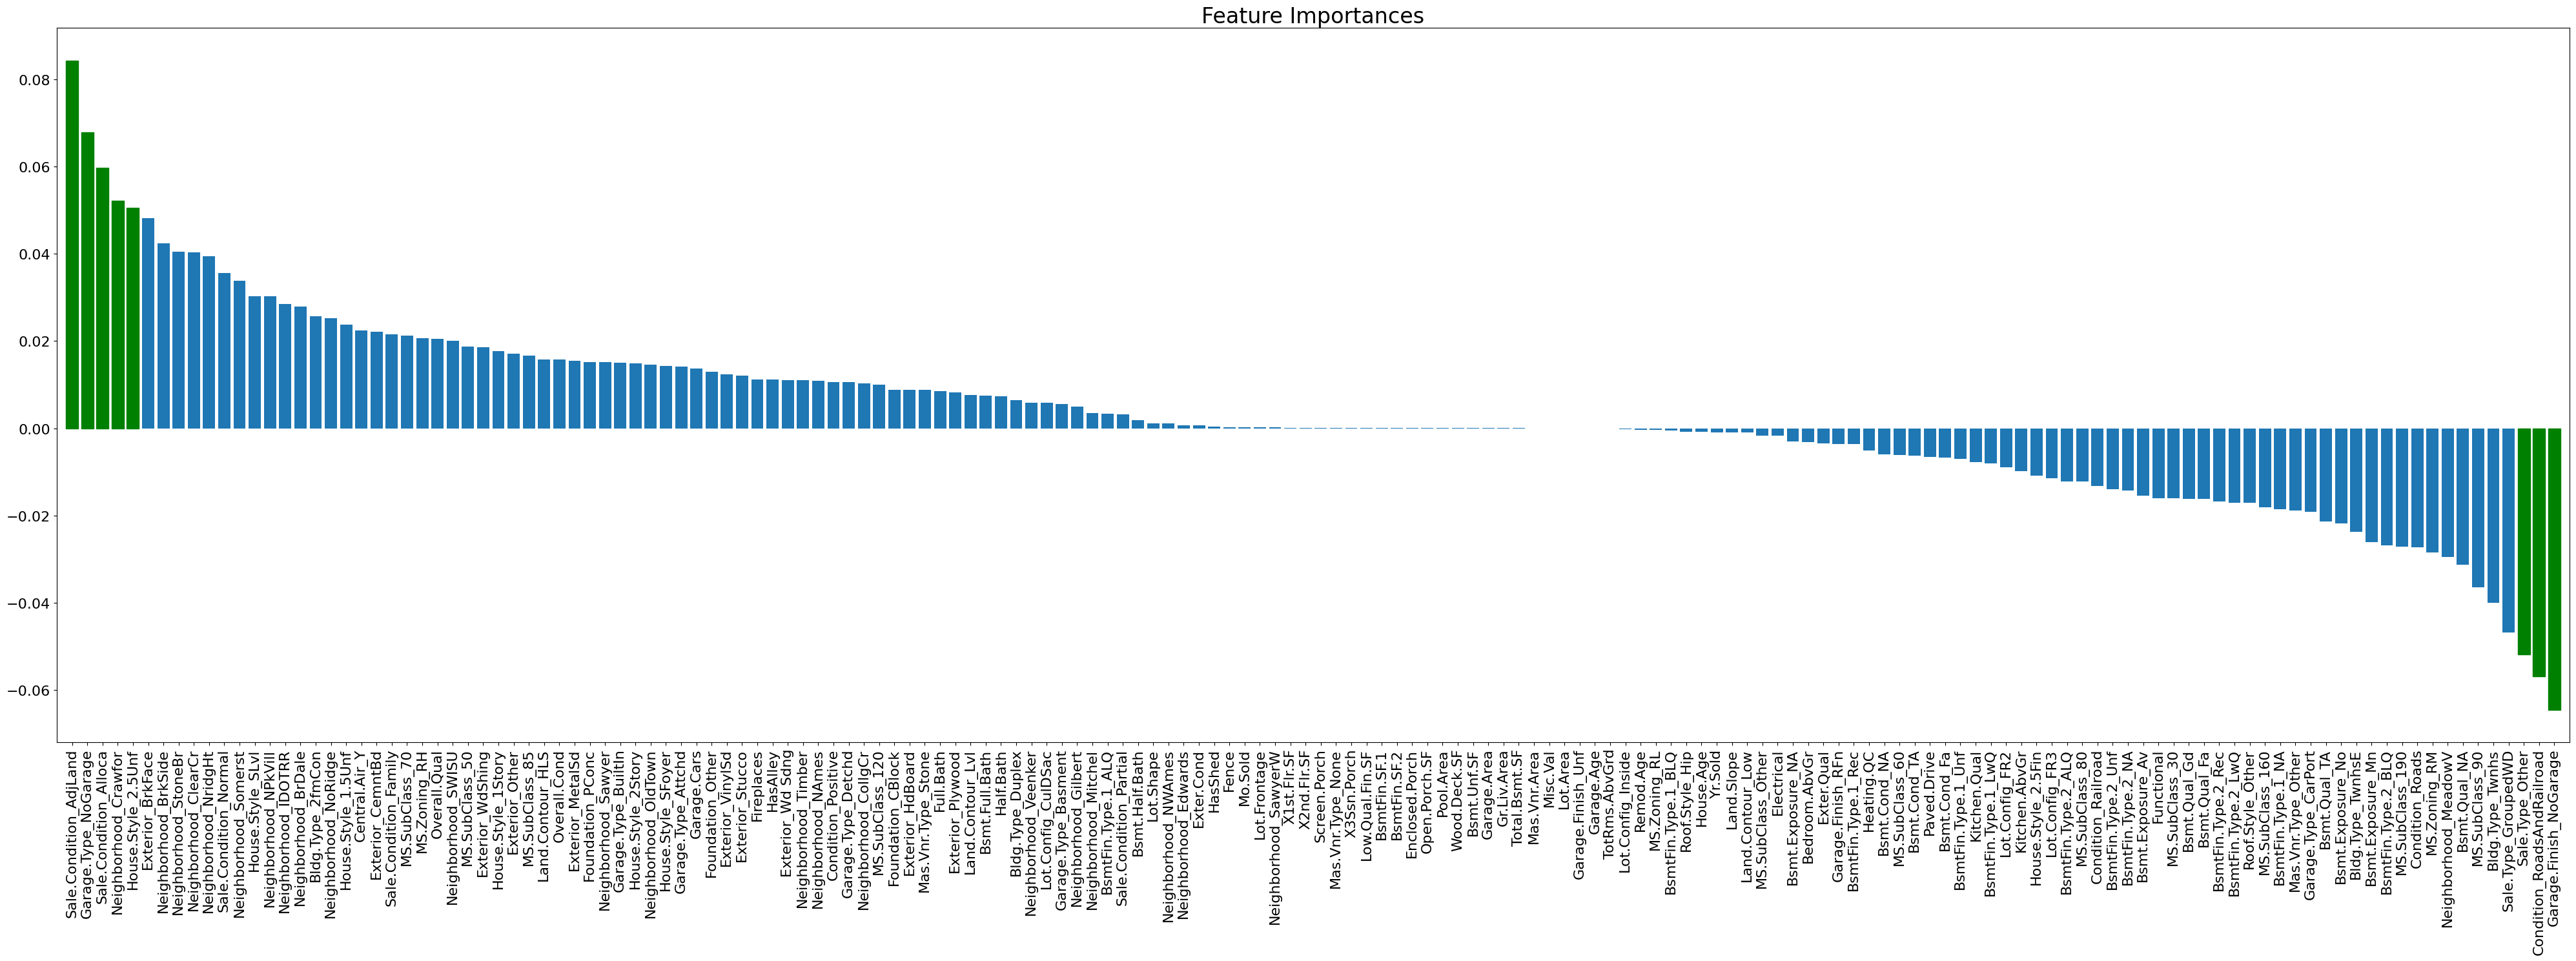

In [91]:
import matplotlib.pyplot as plt

# Get feature importances
best_model = sorted_results[1][1]['best_model']
importances = best_model.coef_

# Get feature names from Xtrain
feature_names = model_data.drop(columns=['SalePrice']).copy().columns

# Sort features by importance in descending order
indices = importances.argsort()[::-1]

# Create a bar chart
plt.figure(figsize=(40, 15))
plt.title("Feature Importances", fontsize=24)  # Increase title fontsize
bars = plt.bar(range(Xtrain.shape[1]), importances[indices], align="center")

# Change color of bars with absolute values greater than 0.6
for i, bar in enumerate(bars):
    if abs(importances[indices][i]) > 0.05:
        bar.set_color('green')

plt.xticks(range(Xtrain.shape[1]), feature_names[indices], rotation=90, fontsize=16)  # Increase x-axis fontsize
plt.yticks(fontsize=16)  # Increase y-axis fontsize
plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()



## Testing ensemble model

In [88]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define base estimators
estimators = [
     ('ridge', RidgeCV()),
     ('lasso', LassoCV())
 ]

# Define the StackingRegressor
ensembleReg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(random_state=42)
 )

# Define the parameter grid for the GridSearchCV
param_grid = {
    'ridge__alphas': [[0.1, 1.0, 10.0]],
    'lasso__alphas': [[0.1, 1.0, 10.0]],
    'final_estimator__n_estimators': [10, 50, 100,200]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(ensembleReg, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(Xtrain, ytrain)

# Get the best estimator and best parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:")
print(best_params)

# Evaluating the model using cross-validation
y_pred = grid_search.best_score_

meanError = 100*((10**np.sqrt(-y_pred))-1)
print("ensembleReg Results: ") 
print(f"Mean Test Score %: {meanError}")


Best Parameters:
{'final_estimator__n_estimators': 50, 'lasso__alphas': [0.1, 1.0, 10.0], 'ridge__alphas': [0.1, 1.0, 10.0]}
ensembleReg Results: 
Mean Test Score %: 12.223945762039667


## Best model evaluation

In [87]:
from sklearn.metrics import mean_squared_error
best_estimator.fit(Xtrain, ytrain)

# Predict on the test set
Y_pred = best_estimator.predict(Xtest)

# Calculate Mean Squared Error
mse = mean_squared_error(ytest, Y_pred)

# Calculate Mean Error Percentage
meanError = 100*((10**np.sqrt(mse))-1)

print("ensembleReg Results on Test Data: ")
print(f"Mean Test Score %: {meanError}")


ensembleReg Results on Test Data: 
Mean Test Score %: 12.94876398468463


## Train with Reduced Features and save the model